In [1]:
import os
import numpy as np
import torch
import re
import csv
import pandas as pd
from io import StringIO
from google.cloud import storage
import matplotlib.pyplot as plt#, mpld3
from sklearn import ensemble
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
from google.cloud import storage
import tempfile
import io
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../ab2.json"

In [2]:
class FeedForwardNet1(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        #import pdb; pdb.set_trace()
        x = self.fc1.forward(x)
        x = F.relu(x)
        x = self.fc2.forward(x)
        x = F.relu(x)
        x = self.fc3.forward(x)
        x = F.dropout(x, 0.2, training = self.training)
        x = F.sigmoid(x)
        return x

def get_latest_model(device, model_dir, gcs_bucket=None, model_filename_prefix=None):
    if model_filename_prefix is None:
        model_filename_prefix = 'inara_'

    if gcs_bucket is not None:
        # Get the latest model from bucket
        model_list = list(gcs_bucket.list_blobs(prefix=model_dir))
        # print(model_list)
        model_list = [model for model in model_list if model_filename_prefix in model.name]
        sorted_model_list = sorted(model_list, key=lambda model: os.path.basename(model.name))
        # print(sorted_model_list)
        model_blob = sorted_model_list[-1]
        tmp_file = tempfile.NamedTemporaryFile()
        model_blob.download_to_file(tmp_file)
        # Setting the data pointer in the file
        tmp_file.seek(0)
        # Load the saved model
        model_dict = torch.load(tmp_file)
        model_filename = model_blob.name
    else:
        # Same as above just from file system
        model_list = glob.glob(os.path.join(model_dir, model_filename_prefix + '*'))
        if len(model_list) == 0:
            print('No model files found.')
            sys.exit(1)
        else:
            sorted_model_list = sorted(model_list)
            model_filename = sorted_model_list[-1]
            model_dict = torch.load(model_filename)
    print('Loaded model:', model_filename)
    return model_dict

def get_model_info(model_dict):
    ret = ['Model type             : {}'.format(model_dict['model_type']),
           'Training epochs        : {:,}'.format(model_dict['epoch']),
           'Training iterations    : {:,}'.format(model_dict['iteration']),
           'Training minibatch size: {:,}'.format(model_dict['minibatch_size']),
           'Seed                   : {}'.format(model_dict['seed']),
           'Initial training loss  : {:.6E}'.format(model_dict['train_loss_history'][0]),
           'Final training loss    : {:.6E}'.format(model_dict['train_loss_history'][-1]),
           'Minimum training loss  : {:.6E}'.format(model_dict['train_loss_min']),
           'Initial validation loss: {:.6E}'.format(model_dict['valid_loss_history'][0]),
           'Final validation loss  : {:.6E}'.format(model_dict['valid_loss_history'][-1]),
           'Minimum validation loss: {:.6E}'.format(model_dict['valid_loss_min'])]
    return '\n'.join(ret)

class DataLoader():
    # Initialising
    def __init__(self, data_dir=None, gcs_bucket=None, max_blobs=None):
        self._data_dir = data_dir

        # If bucket is not given then work with file system
        if gcs_bucket is None:
            self._gcs_enabled = False
            # Get a list of all the files in the training folder
            print('Listing files in dir   : {} ...'.format(data_dir))
            self._files = glob.glob(os.path.join(self._data_dir, '*.csv'))
            if len(self._files) > 0:
                planets_per_file = self.read_data_from_file(self._files[0]).size(0)
        # If bucket is given work with google cloud bucket
        else:
            self._gcs_enabled = True
            # Get a list of all the blobs in the training folder
            # The following call to list_blobs is significantly slow for a bucket containing a large number of files. A faster alternative can be implemented.
            print('Listing blobs in dir   : {} ...'.format(data_dir))
            print('This might take up to several minutes if there are many blobs. A faster implementation is pending.')
            self._files = list(gcs_bucket.list_blobs(prefix=self._data_dir, max_results=max_blobs))
            self._files = [file for file in self._files if 'csv' in file.name]
            if len(self._files) > 0:
                planets_per_file = self.read_data_from_blob(self._files[0]).size(0)

        print('Total number of files  : {:,}'.format(len(self._files)))
        if len(self._files) > 0:
            print('Total number of planets: {:,} (assuming {:,} planets per file)'.format(len(self._files) * planets_per_file, planets_per_file))

        # Creating a buffer by creating a Tensor (empty tensor)
        self._buffer = torch.Tensor()
        self.epoch = 1
        self._file_index = 0
        self.num_files = len(self._files)
        random.shuffle(self._files)

    # General writing and reading methods reused in later parts of the program
    @staticmethod
    def read_data_from_blob(blob):
        data_string = blob.download_as_string().decode('utf-8')
        # Creating a torch tensor here from a single blob (csv format)
        return torch.from_numpy(pd.read_csv(StringIO(data_string), delimiter='\t', header=None).as_matrix()).float()

    @staticmethod
    def read_data_from_file(file_name):
        # Creating a torch tensor here from a single file (csv format)
        return torch.from_numpy(pd.read_csv(file_name, delimiter='\t', header=None).as_matrix()).float()

    @staticmethod
    def write_data_to_file(data, file_name):
        stream = io.StringIO()
        writer = csv.writer(stream, delimiter='\t', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
        for i in range(data.size(0)):
            row = data[i].detach().cpu().numpy()
            writer.writerow(row)
        with open(file_name, 'w') as file:
            file.write(stream.getvalue())

    @staticmethod
    def write_data_to_blob(data, blob):
        stream = io.StringIO()
        writer = csv.writer(stream, delimiter='\t', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
        for i in range(data.size(0)):
            row = data[i].detach().cpu().numpy()
            writer.writerow(row)
        blob.upload_from_string(stream.getvalue())

    # Dangerous method! return all of your data as single tensor - good for validation set but careful!
    def get_all(self):
        all_data = []
        for file in self._files:
            if self._gcs_enabled:
                data = self.read_data_from_blob(file)
            else:
                data = self.read_data_from_file(file)
            data = remove_rows_with_nan(data)
            all_data.append(data)
        return torch.cat(all_data)

    # Creating minibatches from the buffer, if buffer does not have ebough rows it will fill the buffer
    def get_minibatch(self, size=64):
        # Check if we have enough rows in the buffer to create a minibatch
        if self._buffer.size(0) >= size:
            # There are enough rows in the buffer
            # Slice the required number of rows as the minibatch to return
            ret = self._buffer[:size]
            # Remove the sliced minibatch rows from the buffer
            self._buffer = self._buffer[size:]
            return ret
        else:
            # There are not enough rows in the buffer
            # Start a loop for reading files from the files sequence and adding the rows to the buffer
            buffer_ready = False
            while not buffer_ready:
                if self._gcs_enabled:
                    data = self.read_data_from_blob(self._files[self._file_index])
                else:
                    data = self.read_data_from_file(self._files[self._file_index])
                data = remove_rows_with_nan(data)
                self._buffer = torch.cat([self._buffer, data])

                # Check if the buffer has enough rows now to supply the minibatch
                # If yes, this will terminate the buffer-filling loop
                if self._buffer.size(0) >= size:
                    buffer_ready = True

                # Check if we reached the end of the list of files
                # If yes, rewind to the first file, increment the epoch
                self._file_index += 1
                if self._file_index >= len(self._files):
                    random.shuffle(self._files)
                    self._file_index = 0
                    self.epoch += 1
            # Recursive call
            return self.get_minibatch(size)


In [3]:
test_dir = 'test'
model_dir = 'model'
root = 'inara-debug-7c'
gcs_enabled = True
bucket_name = root.replace('gs://', '')
gcs_storage_client = storage.Client()
gcs_bucket = gcs_storage_client.get_bucket(bucket_name)
device = torch.device('cpu')
observation_dim = 2696
# 11515
# Parameter dimension (the full parameter range)
params_dim = 27  # 39
# The subset of parameters that the neural network predicts
# Upper limit not included (PyTorch slicing)
params_slice = [13, 25]  # [25, 36]

In [8]:
save = False

In [30]:
print('\n*** TEST MODE ***\n')

print('Checking test files in dir : {} ...'.format(test_dir))
if gcs_enabled:
    test_files = list(gcs_bucket.list_blobs(prefix=test_dir))
    test_files = [os.path.basename(file.name) for file in test_files if 'csv' in file.name]
else:
    test_files = glob.glob(os.path.join(test_dir, '*.csv'))
    test_files = [os.path.basename(file) for file in test_files]

# Filtering out any test output files in the subdirectories that may be remaining from a previous test execution. We don't want to treat them as test input files.
test_files = [file for file in test_files if 'output' not in file]

if len(test_files) == 0:
    print('No files found in test_dir: {}'.format(test_dir))
    sys.exit(1)

print('\nFound test files:')
for test_file in test_files:
    print(test_file)

if not gcs_enabled:
    full_path = os.path.join(os.path.join(root, test_dir), 'predictions')
    if not os.path.exists(full_path):
        print('\nDirectory does not exists, creating: {} ...'.format(full_path))
        os.makedirs(full_path)

print('\nChecking models in dir : {} ...'.format(model_dir))
if gcs_enabled:
    model_files = list(gcs_bucket.list_blobs(prefix=model_dir))
    model_files = [os.path.basename(file.name) for file in model_files if '.model' in file.name]
else:
    model_files = glob.glob(os.path.join(model_dir, '*.model'))
    model_files = [os.path.basename(file) for file in model_files]

regex = r"inara_seed_(.*)_snapshot"
matches = list(re.finditer(regex, '\n'.join(model_files), re.MULTILINE))
seeds = [match.group(1) for match in matches]
seeds = list(set(seeds))

print('\nFound model files:')
for model_file in model_files:
    print(model_file)

print('\nFound random number seeds:')
for seed in seeds:
    print(seed)

output = np.zeros((len(seeds),8,12))
print('\nIterating through model ensemble with {} seeds'.format(len(seeds)))
for seed in seeds:
    print('\n** Loading latest model snapshot for seed: {} ...'.format(seed))
    model_dict = get_latest_model(device, model_dir, gcs_bucket, model_filename_prefix='inara_seed_'+str(seed))
    print('Loaded model info:')
    model_info = get_model_info(model_dict)
    print(model_info)
    model = model_dict['model']
    model.to(device)
    # Set the model in evaluation mode
#     model.eval()

    for test_file in [test_files[0]]:
        print('\nReading test input file: {} ...'.format(test_file))
        if gcs_enabled:
            test_input = DataLoader.read_data_from_blob(gcs_bucket.get_blob(os.path.join(test_dir, test_file)))
        else:
            test_input = DataLoader.read_data_from_file(os.path.join(root, os.path.join(test_dir, test_file)))
        test_input = test_input[:, params_dim:]
        test_input = test_input.to(device)
        # Run the neural network, get test output
        print('Running model...')
        print('THE SHAPE OF THE TEST_INPUT IS :', test_input.shape)
        test_output = model.forward(test_input)
        output[int(seed)] = test_output.data
        test_output_file_name = test_file.replace('.csv', '') + '_output_seed_{}.csv'.format(seed)
        test_output_filename_full_path = os.path.join(test_dir, os.path.join('predictions', test_output_file_name))
        if save:
            print('Saving test output file: {} ...'.format(test_output_filename_full_path))
            if gcs_enabled:
                blob = gcs_bucket.blob(test_output_filename_full_path)
                DataLoader.write_data_to_blob(test_output, blob)
            else:
                DataLoader.write_data_to_file(test_output, test_output_filename_full_path)


*** TEST MODE ***

Checking test files in dir : test ...

Found test files:
fdl_01c5a352-a868-4169-8b08-b4c7b910940d.csv
fdl_0257a642-5a07-4852-802b-d3003f774b49.csv
fdl_043f9b5a-c359-4cd7-bfa5-400606f730e4.csv
fdl_0452ff0b-5b22-40d5-9935-475c2d0e66f5.csv
fdl_073aff27-f26e-4654-a039-3facca6de4fd.csv
fdl_07aca9f1-7892-49e3-95cf-ca99838d96cb.csv
fdl_091dc46c-2396-4cb5-b3f6-6359b2531818.csv
fdl_097f1b06-af92-4945-b56a-98b0d708749a.csv
fdl_09b439e7-35d9-4aca-a4be-1dc6345ca6df.csv
fdl_0b45a03d-c39f-44cb-83f6-e0559dc3e032.csv
fdl_0b72f690-70f9-4c29-a4d5-5311ba616288.csv
fdl_0ca32c9e-1f02-4987-b20f-946f11d4f468.csv
fdl_0ca44d51-e2b5-438c-8dd6-ec75c59b86e2.csv
fdl_0ccb0643-8ac8-483a-ae63-6d5f48909427.csv
fdl_0e916674-fbe2-4214-8c47-1d12b5b8153d.csv
fdl_11fef18c-f5e7-4e9b-b3af-458107fcc080.csv
fdl_122f5cce-0caa-49d6-a4d6-d2abed3bfa31.csv
fdl_137b146b-3cec-4baf-83b9-eb30c9d547f7.csv
fdl_14cb7929-e61a-47ef-932a-77b0a84dd3b9.csv
fdl_14d2882e-af8d-4287-9845-46fd8938cac5.csv
fdl_15512bcd-bd7d-4133-

/Users/adcobb/anaconda/envs/tensorflow/lib/python3.6/site-packages/torch/serialization.py:333: UserWarning: Couldn't retrieve source code for container of type FeedForwardNet1. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


Loaded model: model/inara_seed_5_snapshot_1533321450.model
Loaded model info:
Model type             : FF
Training epochs        : 5
Training iterations    : 140
Training minibatch size: 128
Seed                   : 5
Initial training loss  : 1.462505E-03
Final training loss    : 4.839766E-04
Minimum training loss  : 4.219377E-04
Initial validation loss: 4.455332E-04
Final validation loss  : 4.917218E-04
Minimum validation loss: 4.445711E-04

Reading test input file: fdl_01c5a352-a868-4169-8b08-b4c7b910940d.csv ...
Running model...
THE SHAPE OF THE TEST_INPUT IS : torch.Size([8, 2696])

** Loading latest model snapshot for seed: 4 ...
Loaded model: model/inara_seed_4_snapshot_1533320738.model
Loaded model info:
Model type             : FF
Training epochs        : 5
Training iterations    : 140
Training minibatch size: 128
Seed                   : 4
Initial training loss  : 1.561970E-03
Final training loss    : 4.728195E-04
Minimum training loss  : 3.834644E-04
Initial validation loss: 

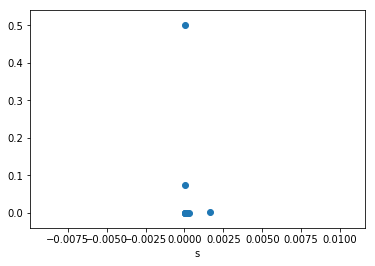

In [37]:
plt.scatter(output[:,6,0],output[:,6,1])
plt.xlabel('s')
plt.xlabel('s')
plt.show()

In [38]:
if gcs_enabled:
    test_input = DataLoader.read_data_from_blob(gcs_bucket.get_blob(os.path.join(test_dir, test_file)))
else:
    test_input = DataLoader.read_data_from_file(os.path.join(root, os.path.join(test_dir, test_file)))



In [43]:
y_true = test_input[:,:params_dim].data

In [44]:
y_true.shape

torch.Size([8, 27])

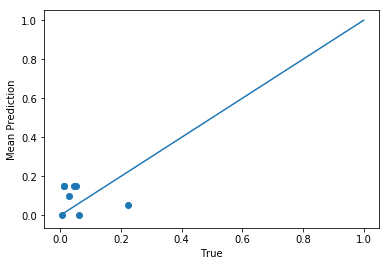

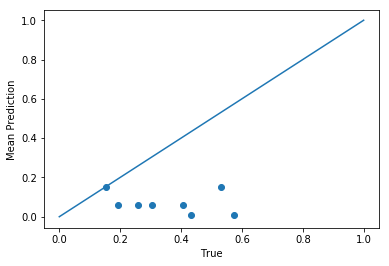

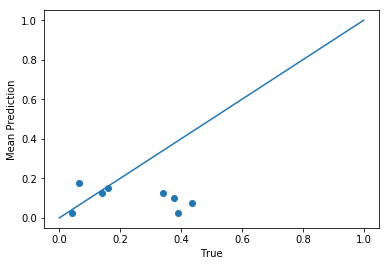

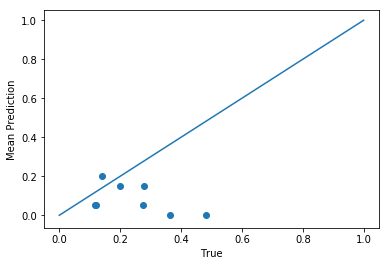

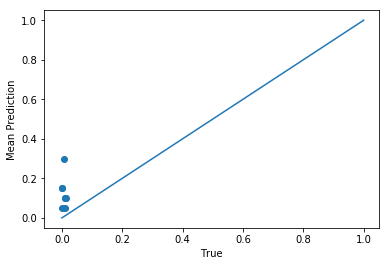

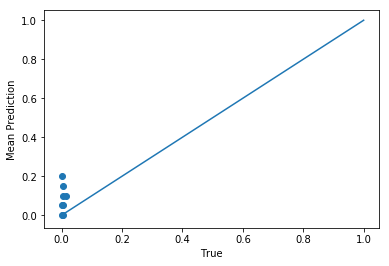

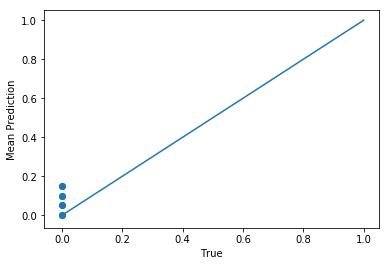

In [51]:
x = np.linspace(0,1,2)
for n in range(11):
    plt.ylabel('Mean Prediction')
    plt.xlabel('True')
    plt.scatter(y_true[:,13+n],output.mean(0)[:,n])
    plt.plot(x,x)
    plt.show()

In [53]:
loss = model_dict['train_loss_history']
loss_val = model_dict['valid_loss_history']

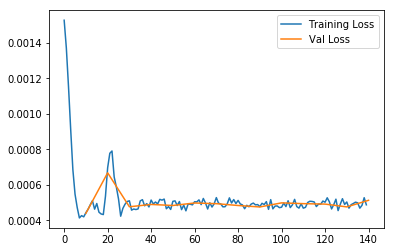

In [59]:
plt.plot(loss, label = 'Training Loss')
plt.plot(val_iter, loss_val, label = 'Val Loss')
plt.legend()
plt.show()

In [56]:
val_iter = model_dict['valid_loss_history_iter']

In [31]:
output.shape

(10, 8, 12)

In [16]:
test_files

['fdl_01c5a352-a868-4169-8b08-b4c7b910940d.csv',
 'fdl_0257a642-5a07-4852-802b-d3003f774b49.csv',
 'fdl_043f9b5a-c359-4cd7-bfa5-400606f730e4.csv',
 'fdl_0452ff0b-5b22-40d5-9935-475c2d0e66f5.csv',
 'fdl_073aff27-f26e-4654-a039-3facca6de4fd.csv',
 'fdl_07aca9f1-7892-49e3-95cf-ca99838d96cb.csv',
 'fdl_091dc46c-2396-4cb5-b3f6-6359b2531818.csv',
 'fdl_097f1b06-af92-4945-b56a-98b0d708749a.csv',
 'fdl_09b439e7-35d9-4aca-a4be-1dc6345ca6df.csv',
 'fdl_0b45a03d-c39f-44cb-83f6-e0559dc3e032.csv',
 'fdl_0b72f690-70f9-4c29-a4d5-5311ba616288.csv',
 'fdl_0ca32c9e-1f02-4987-b20f-946f11d4f468.csv',
 'fdl_0ca44d51-e2b5-438c-8dd6-ec75c59b86e2.csv',
 'fdl_0ccb0643-8ac8-483a-ae63-6d5f48909427.csv',
 'fdl_0e916674-fbe2-4214-8c47-1d12b5b8153d.csv',
 'fdl_11fef18c-f5e7-4e9b-b3af-458107fcc080.csv',
 'fdl_122f5cce-0caa-49d6-a4d6-d2abed3bfa31.csv',
 'fdl_137b146b-3cec-4baf-83b9-eb30c9d547f7.csv',
 'fdl_14cb7929-e61a-47ef-932a-77b0a84dd3b9.csv',
 'fdl_14d2882e-af8d-4287-9845-46fd8938cac5.csv',
 'fdl_15512bcd-bd7d-

In [58]:
from __future__ import print_function

bucket_name = 'inara-debug-7c'
gcs_storage_client = storage.Client()
print('Current buckets in the account:')
# List all the available buckets
for bucket in list(gcs_storage_client.list_buckets()):
    print(' ' + bucket.name)
print('Setting root bucket: {} ...'.format(bucket_name))
gcs_bucket = gcs_storage_client.get_bucket(bucket_name)

def read_data_from_blob(blob):
        data_string = blob.download_as_string().decode('utf-8')
        # Creating a torch tensor here from a single blob (csv format)
        return pd.read_csv(StringIO(data_string), delimiter='\t', header=None)

dir = 'train'
file_list = list(gcs_bucket.list_blobs(prefix=dir))
print(file_list[1])

num_inputs = 11515
num_outputs = 11
num_examples = 1000



data = read_data_from_blob(file_list[1])
print('size of data from one file:'+str(len(data)))


for i in range(2,int(num_examples/10)+1):
    print('Adding file number '+str(i))
    data = pd.concat([data, read_data_from_blob(file_list[i])])
    
np.array(data).shape


Current buckets in the account:
 artifacts.astrobiology-team-2.appspot.com
 astrobiology-2-data
 astrobiology-papers
 inara
 inara-debug-1
 inara-debug-2
 inara-debug-3
 inara-debug-4
 inara-debug-5
 inara-debug-6
 inara-debug-7
 inara-debug-7b
 inara-debug-7c
 inara-scale-test-1
Setting root bucket: inara-debug-7c ...
<Blob: inara-debug-7c, train/fdl_012f09c1-aca1-4438-8799-d21adcbf2d55.csv>
size of data from one file:9
Adding file number 2
Adding file number 3
Adding file number 4
Adding file number 5
Adding file number 6
Adding file number 7
Adding file number 8
Adding file number 9
Adding file number 10
Adding file number 11
Adding file number 12
Adding file number 13
Adding file number 14
Adding file number 15
Adding file number 16
Adding file number 17
Adding file number 18
Adding file number 19
Adding file number 20
Adding file number 21
Adding file number 22
Adding file number 23
Adding file number 24
Adding file number 25
Adding file number 26
Adding file number 27
Adding file

(828, 2723)

In [59]:
x_data = data.iloc[:,27:]
y_data = data.iloc[:,13:25]
y_data2 = data.iloc[:,1:3]
print(np.hstack([y_data, y_data2]).shape)
y_data = np.hstack([y_data, y_data2])

(828, 14)


https://github.com/exoclime/HELA/blob/ffe2f0e17c86c8b593eaec4a050ec610865e36d1/example_dataset/example_dataset.json

In [60]:
print(np.any(np.isnan(x_data)))
print(np.any(np.isnan(y_data)))
print(np.all(np.isfinite(x_data)))
print(np.all(np.isfinite(y_data)))

False
False
True
True


In [61]:
x_data1 = np.array(x_data)[np.where(~np.isnan(x_data))]
y_data1 = np.array(y_data)[np.where(~np.isnan(y_data))]

In [62]:
x_data.shape

(828, 2696)

In [63]:
y_data.shape

(828, 14)

In [64]:
class Model:
    
    def __init__(self, num_trees, num_jobs,ranges, verbose=1):
        scaler = MinMaxScaler(feature_range=(0, 100))
        rf = ensemble.RandomForestRegressor(n_estimators=num_trees,
                                            oob_score=True,
                                            verbose=verbose,
                                            n_jobs=num_jobs,
                                            max_features="sqrt",
                                            min_impurity_decrease=0.01)
        self.scaler = scaler
        self.rf = rf
        self.num_trees = num_trees
        self.num_jobs = num_jobs
        self.verbose = verbose
        self.ranges = ranges
    
    def _scaler_fit(self, y):
        if y.ndim == 1:
            y = y[:, None]
        
        self.scaler.fit(y)
    
    def _scaler_transform(self, y):
        if y.ndim == 1:
            y = y[:, None]
            return self.scaler.transform(y)[:, 0]
        
        return self.scaler.transform(y)
    
    def _scaler_inverse_transform(self, y):
        
        if y.ndim == 1:
            y = y[:, None]
            return self.scaler.inverse_transform(y)[:, 0]
        
        return self.scaler.inverse_transform(y)
    
    def fit(self, x, y):
        self._scaler_fit(y)
        self.rf.fit(x, self._scaler_transform(y))
    
    def predict(self, x):
        pred = self.rf.predict(x)
        return self._scaler_inverse_transform(pred)
    
#     def get_params(self, deep=True):
#         return {"num_trees": self.num_trees, "num_jobs": self.num_jobs,
#                 "names": self.names, "ranges": self.ranges,
#                 "colors": self.colors,
#                 "verbose": self.verbose}
    
    def trees_predict(self, x):
        
        if x.ndim > 1:
            raise ValueError("x.ndim must be 1")
        
        preds = np.array([i.predict(x[None, :])[0] for i in self.rf.estimators_])
        return self._scaler_inverse_transform(preds)

In [65]:
def train_model(training_x, training_y, num_trees=1000, num_jobs=5, verbose=1):
#     pipeline = Model(num_trees, num_jobs,
#                         names=dataset.names,
#                         ranges=dataset.ranges, [[0, 3000], [-13, 0], [-13, 0], [-13, 0], [-13, 0]]
#                         colors=dataset.colors,
#                         verbose=verbose)
    pipeline = Model(num_trees, num_jobs,
                    ranges=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1]],
                    verbose=verbose)
    pipeline.fit(training_x, training_y)
    return pipeline


def test_model(model, dataset, output_path):
    
    if dataset.testing_x is None:
        return
    
    logger.info("Testing model...")
    pred = model.predict(dataset.testing_x)
    r2scores = {name_i: metrics.r2_score(real_i, pred_i)
                    for name_i, real_i, pred_i in zip(dataset.names, dataset.testing_y.T, pred.T)}
    print("Testing scores:")
    for name, values in r2scores.items():
        print("\tR^2 score for {}: {:.3f}".format(name, values))
    
    logger.info("Plotting testing results...")
    fig = plot.predicted_vs_real(dataset.testing_y, pred, dataset.names, dataset.ranges)
    fig.savefig(os.path.join(output_path, "predicted_vs_real.pdf"),
                bbox_inches='tight')


def compute_feature_importance(model, dataset, output_path):
    
    logger.info("Computing feature importance for individual parameters...")
    regr = multioutput.MultiOutputRegressor(model, n_jobs=1)
    regr.fit(dataset.training_x, dataset.training_y)
    
    fig = plot.feature_importances(forests=[i.rf for i in regr.estimators_] + [model.rf],
                                   names=dataset.names + ["joint prediction"],
                                   colors=dataset.colors + ["C0"])
    
    fig.savefig(os.path.join(output_path, "feature_importances.pdf"),
                bbox_inches='tight')


def prediction_ranges(preds):
    
    percentiles = (np.percentile(pred_i, [50, 16, 84]) for pred_i in preds.T)
    return np.array([(a, c-a, a-b) for a, b, c in percentiles])


def main_train(training_dataset, model_path,
               num_trees, num_jobs,
               feature_importance, quiet,
               **kwargs):
    
    logger.info("Loading dataset '{}'...".format(training_dataset))
    dataset = load_dataset(training_dataset)
    
    logger.info("Training model...")
    model = train_model(dataset, num_trees, num_jobs, not quiet)
    
    maybe_makedirs(model_path)
    model_file = os.path.join(model_path, "model.pkl")
    logger.info("Saving model to '{}'...".format(model_file))
    joblib.dump(model, model_file)
    
    logger.info("Printing model information...")
    print("OOB score: {:.4f}".format(model.rf.oob_score_))
    
    test_model(model, dataset, model_path)
    
    if feature_importance:
        compute_feature_importance(model, dataset, model_path)


def main_predict(model_path, data_file, output_path, plot_posterior, **kwargs):
    
    model_file = os.path.join(model_path, "model.pkl")
    logger.info("Loading random forest from '{}'...".format(model_file))
    model = joblib.load(model_file)
    
    logger.info("Loading data from '{}'...".format(data_file))
    data, _ = load_data_file(data_file, model.rf.n_features_)
    
    preds = model.trees_predict(data[0])
    pred_ranges = prediction_ranges(preds)
    
    for name_i, pred_range_i in zip(model.names, pred_ranges):
        print("Prediction for {}: {:.3g} [+{:.3g} -{:.3g}]".format(name_i, *pred_range_i))
    
    if plot_posterior:
        logger.info("Plotting and saving the posterior matrix...")
        fig = plot.posterior_matrix(preds, None,
                                    names=model.names,
                                    ranges=model.ranges,
                                    colors=model.colors)
        maybe_makedirs(output_path)
        fig.savefig(os.path.join(output_path, "posterior_matrix.pdf"),
                    bbox_inches='tight')


def show_usage(parser, **kwargs):
    parser.print_help()

In [66]:
pipeline = train_model(training_x=np.array(x_data), training_y=np.array(y_data))

[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 1000 out of 1000 | elapsed:    2.4s finished


In [67]:
predictions = pipeline.trees_predict(np.array(x_data)[0,:])

In [68]:
predictions.shape

(1000, 14)

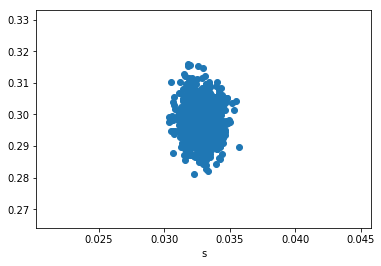

In [69]:
plt.scatter(predictions[:,0],predictions[:,1])
plt.xlabel('s')
plt.xlabel('s')
plt.show()

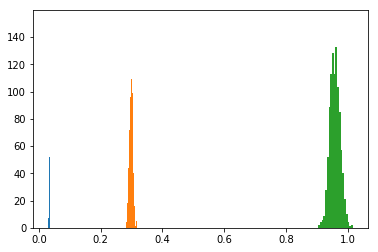

In [70]:

plt.hist(predictions[:,0],bins=20)
plt.hist(predictions[:,1],bins=20)
plt.hist(predictions[:,-1],bins=20)
plt.show()

In [71]:
print(y_data[0])

[5.73950308e-02 5.69749966e-01 7.28488701e-02 2.62975851e-01
 1.30022231e-02 5.57234048e-03 1.00568671e-02 6.43654394e-04
 4.48534042e-03 3.24883357e-03 1.50604225e-05 5.96271863e-06
 5.82661424e+03 1.00103886e+00]


### Generate Test Data

In [78]:
from __future__ import print_function

bucket_name = 'inara-debug-7c'
gcs_storage_client = storage.Client()
print('Current buckets in the account:')
# List all the available buckets
for bucket in list(gcs_storage_client.list_buckets()):
    print(' ' + bucket.name)
print('Setting root bucket: {} ...'.format(bucket_name))
gcs_bucket = gcs_storage_client.get_bucket(bucket_name)

def read_data_from_blob(blob):
        data_string = blob.download_as_string().decode('utf-8')
        # Creating a torch tensor here from a single blob (csv format)
        return pd.read_csv(StringIO(data_string), delimiter='\t', header=None)

dir = 'test'
file_list = list(gcs_bucket.list_blobs(prefix=dir))
print(file_list[1])

num_inputs = 11515
num_outputs = 11
num_examples = 30



data_test = read_data_from_blob(file_list[1])
print('size of data from one file:'+str(len(data)))


for i in range(2,int(num_examples/10)+1):
    print('Adding file number '+str(i))
    data_test = pd.concat([data, read_data_from_blob(file_list[i])])
    
np.array(data).shape


Current buckets in the account:
 artifacts.astrobiology-team-2.appspot.com
 astrobiology-2-data
 astrobiology-papers
 inara
 inara-debug-1
 inara-debug-2
 inara-debug-3
 inara-debug-4
 inara-debug-5
 inara-debug-6
 inara-debug-7
 inara-debug-7b
 inara-debug-7c
 inara-scale-test-1
Setting root bucket: inara-debug-7c ...
<Blob: inara-debug-7c, test/fdl_043f9b5a-c359-4cd7-bfa5-400606f730e4.csv>
size of data from one file:24
Adding file number 2
Adding file number 3


(24, 2723)

In [79]:
x_data_test = data_test.iloc[:,27:]
y_data_test = data_test.iloc[:,13:25]
y_data2_test = data_test.iloc[:,1:3]
print(np.hstack([y_data_test, y_data2_test]).shape)
y_data_test = np.hstack([y_data_test, y_data2_test])

(33, 14)


In [80]:
predictions_test = pipeline.trees_predict(np.array(x_data_test)[0,:])

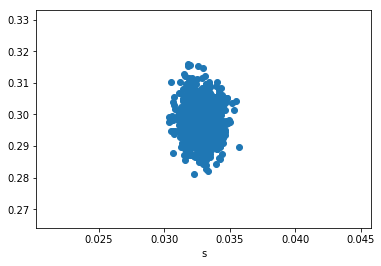

In [81]:
plt.scatter(predictions_test[:,0],predictions_test[:,1])
plt.xlabel('s')
plt.xlabel('s')
plt.show()

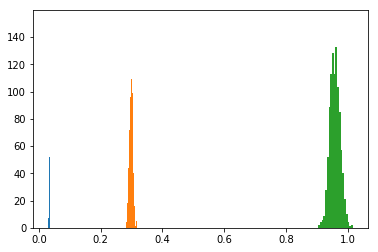

In [82]:
plt.hist(predictions_test[:,0],bins=20)
plt.hist(predictions_test[:,1],bins=20)
plt.hist(predictions_test[:,-1],bins=20)
plt.show()

In [86]:
PRED = np.zeros((y_data_test.shape[0],1000,14))
for planet in range(y_data_test.shape[0]):
    PRED[planet] = pipeline.trees_predict(np.array(x_data_test)[planet,:])
# predictions_test = pipeline.trees_predict(np.array(x_data_test)[0,:])

In [1]:
# TO DO plot x vs y

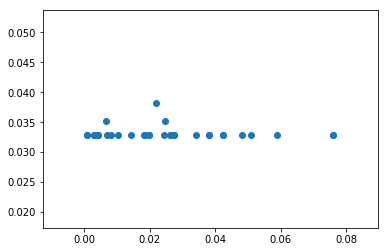

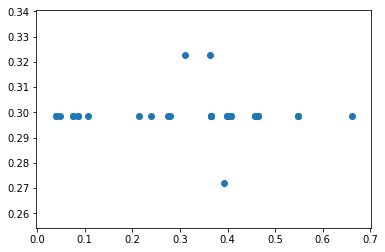

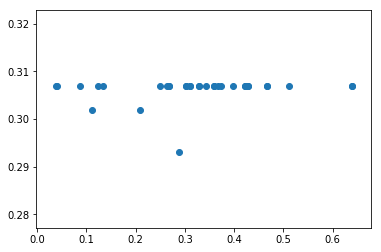

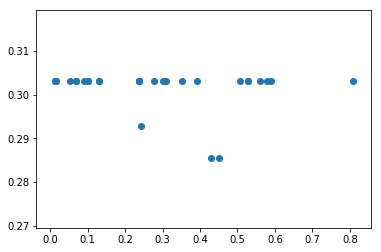

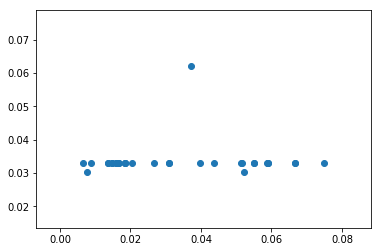

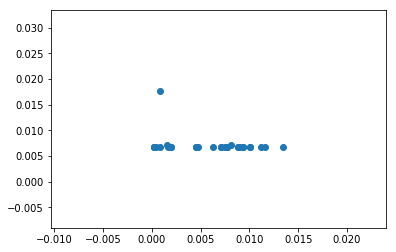

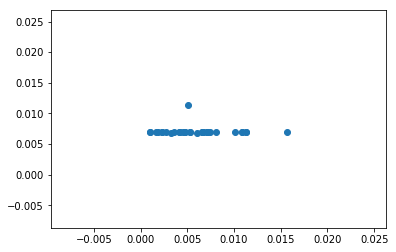

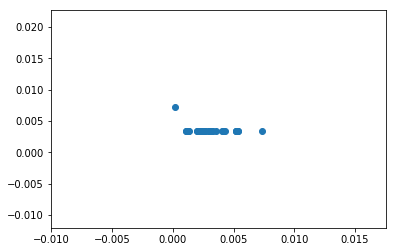

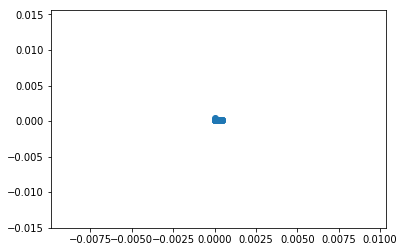

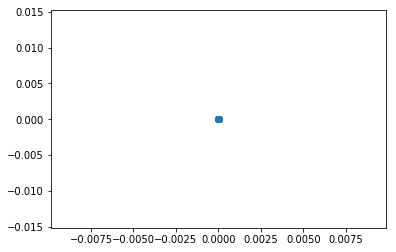

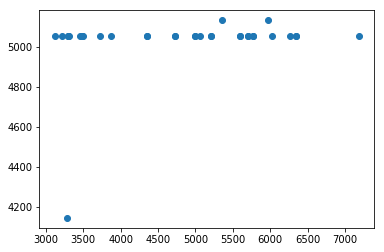

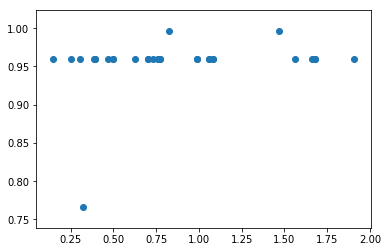

In [89]:
for mol in range(14):
    plt.scatter(y_data_test[:,mol],PRED.mean(1)[:,mol])
    plt.show()

In [87]:
PRED.mean(1).shape

(33, 14)

In [90]:
y_data_test

array([[1.04278842e-02, 2.75152456e-01, 3.73968117e-01, 3.01572747e-01,
        1.68215695e-02, 7.52694644e-03, 5.74308383e-03, 3.67317690e-03,
        1.85327054e-03, 3.13847737e-03, 1.15428835e-04, 6.84307354e-06,
        7.18622561e+03, 1.56238539e+00],
       [2.43194278e-02, 2.14754427e-01, 1.23673964e-01, 5.88814665e-01,
        2.68058815e-02, 4.78272418e-03, 3.76625684e-03, 5.76152183e-04,
        1.01300176e-02, 2.25269138e-03, 1.17839776e-04, 5.95216673e-06,
        3.11706551e+03, 2.50244667e-01],
       [1.81677749e-02, 2.38330439e-01, 3.67837914e-01, 3.09402382e-01,
        3.98018925e-02, 1.11725512e-02, 6.62303467e-03, 1.51492300e-03,
        1.64859634e-03, 5.26261599e-03, 2.26950369e-04, 1.09266378e-05,
        3.31283026e+03, 3.85242070e-01],
       [4.82444292e-02, 6.61051813e-01, 1.33298928e-01, 8.96317067e-02,
        4.38370080e-02, 7.59288750e-03, 5.71266182e-03, 9.75434781e-04,
        4.14779049e-03, 5.17632078e-03, 3.16479505e-04, 1.45403675e-05,
        3.722